In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1005. Miscellaneous Analyses/P1005.5. Yael RNAseq Grant/P1005.5.3. Analyses/P1005.5.3.1 DESeq2/Output')
cur_date = "010924"

library(readxl)
library(openxlsx)
library(tidyverse)
library(reshape2)
library(data.table)
library(factoextra)
library(ggrepel)
library(pheatmap)
library(DESeq2)

# reading in files
count_df = data.frame(read_excel("Input/Yael_Counts_120223.xlsx")) 
subject_info_df = data.frame(read_excel("Input/SubjectInfo_120223.xlsx", sheet = 2))
asthma_gene_list_df = data.frame(read_excel("Input/Paper Gene List.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from

In [2]:
head(count_df)
head(subject_info_df)
head(asthma_gene_list_df)

,Gene,X1911_1,X1911_19,X1911_2,X1911_20,X1911_21,X1911_22,X1911_3,X1911_4,X1911_55,⋯,X2009_14,X2009_15,X2009_2,X2009_3,X2009_4,X2009_5,X2009_6,X2009_7,X2009_8,X2009_9
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CHAC1_1279,56,20,12,22,12,25,23,17,27,⋯,57,90,14,18,33,46,17,15,36,13
2,GLRX_2674,124,581,356,358,661,657,304,561,421,⋯,530,462,599,503,677,272,447,477,475,454
3,MEFV_4116,0,0,0,0,0,1,5,0,3,⋯,0,0,0,4,0,0,0,1,0,0
4,STXBP1_6866,55,95,172,120,121,77,200,97,85,⋯,109,99,121,92,71,132,136,143,165,183
5,AKAP8L_196,93,37,35,28,50,26,41,24,33,⋯,84,53,32,20,51,26,28,34,36,33
6,AKR1C1_199,670,723,513,415,1112,418,559,385,767,⋯,836,492,642,524,381,185,546,529,214,400


,Original_Sample_ID,Original_Subject_No,Subject_No,Subject_ID,Sample_ID,Replicate,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,X1911_62,NBL 190,1,AS_1,AS_1_C.1,1,F,B,NH,47,23.7,AS,C,Air
2,X1911_56,NBL 190,1,AS_1,AS_1_F.1,1,F,B,NH,47,23.7,AS,F,PGGLY
3,X1911_20,NBL 190,1,AS_1,AS_1_C.2,2,F,B,NH,47,23.7,AS,C,Air
4,X1911_2,NBL 190,1,AS_1,AS_1_S.1,1,F,B,NH,47,23.7,AS,S,PGGLY
5,X1911_64,NBL 193,2,AS_2,AS_2_C.1,1,F,W,NH,19,19.5,AS,C,Air
6,X1911_58,NBL 193,2,AS_2,AS_2_F.1,1,F,W,NH,19,19.5,AS,F,PGGLY


,Gene.Symbol,k,Hedges.g,std.error,tau.2,z.value,p.value,q.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CEACAM5,8,1.0939910,0.1100273,0.01261454,9.942911,2.71e-23,1.00e-18
2,C3,8,-0.8490307,0.0983399,0.00000000,-8.633633,5.94e-18,1.10e-13
3,MUC5AC,7,0.8086030,0.1008032,0.00000000,8.021602,1.04e-15,1.29e-11
4,FUT3,8,0.7626832,0.0976211,0.00000000,7.812685,5.60e-15,5.17e-11
5,TCN1,7,0.7701838,0.1001925,0.00000000,7.687039,1.51e-14,9.33e-11
6,DQX1,8,0.7491184,0.0976080,0.00000000,7.674763,1.66e-14,9.33e-11


Using DESeq2 to determine if there are genes differentially expression after exposure to nicotine products in asthmatics vs. control subjects.

In [3]:
# first replacing the column names in the count df with sample ids that are more descriptive of the subjects
# also filtering for asthma genes
cleaned_count_df = count_df %>%
    separate(Gene, sep = "_", c("Gene", NA)) %>%
    # only subsetting for asthma genes we're interested in 
    filter(Gene %in% asthma_gene_list_df$Gene.Symbol) %>%
    relocate(.after = Gene, subject_info_df$Original_Sample_ID) 

colnames(cleaned_count_df)[2:40] = subject_info_df$Sample_ID
head(cleaned_count_df)

,Gene,AS_1_C.1,AS_1_F.1,AS_1_C.2,AS_1_S.1,AS_2_C.1,AS_2_F.1,AS_2_C.2,AS_2_S.1,AS_3_C.1,⋯,NAS_8_C.2,NAS_8_S.1,NAS_9_C.1,NAS_9_F.1,NAS_9_C.2,NAS_9_S.1,NAS_10_C.1,NAS_10_F.1,NAS_10_C.2,NAS_10_S.1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,STXBP1,106,108,120,172,132,173,77,97,124,⋯,95,55,124,213,121,200,92,112,143,109
2,CTSL,197,188,224,170,180,143,192,164,150,⋯,141,479,234,179,212,298,108,164,165,206
3,ALDH18A1,16,17,27,40,10,21,29,18,22,⋯,22,68,12,17,19,19,29,22,32,37
4,ECH1,0,5,0,0,38,53,23,47,31,⋯,24,67,24,38,24,48,26,26,10,19
5,C3,1164,1576,1344,1268,179,206,422,301,525,⋯,1916,5037,1069,275,1551,776,353,576,635,1446
6,CASP7,790,932,964,1046,800,876,770,800,867,⋯,728,1500,853,892,930,1051,814,973,904,1033


In [4]:
# df now contains duplicate genes since the numbers were removed to match the asthma gene list
# creating a new col that identifies unique genes
make.unique = function(x, sep){
    # Function for making unique names. Input = vector (x) and what separator you want to use (sep), 
    # output = vector with duplicate names made unique using the separator and numbers
    ave(x, x, FUN = function(a){if(length(a) > 1){paste(a, 1:length(a), sep = sep)} 
                                else {a}})
}

# calling function
cleaned_count_df <- cleaned_count_df %>%
    mutate(Unique_Gene = make.unique(Gene, sep = "_")) %>%
    relocate(Unique_Gene, .after = Gene)

head(cleaned_count_df)

,Gene,Unique_Gene,AS_1_C.1,AS_1_F.1,AS_1_C.2,AS_1_S.1,AS_2_C.1,AS_2_F.1,AS_2_C.2,AS_2_S.1,⋯,NAS_8_C.2,NAS_8_S.1,NAS_9_C.1,NAS_9_F.1,NAS_9_C.2,NAS_9_S.1,NAS_10_C.1,NAS_10_F.1,NAS_10_C.2,NAS_10_S.1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,STXBP1,STXBP1,106,108,120,172,132,173,77,97,⋯,95,55,124,213,121,200,92,112,143,109
2,CTSL,CTSL_1,197,188,224,170,180,143,192,164,⋯,141,479,234,179,212,298,108,164,165,206
3,ALDH18A1,ALDH18A1,16,17,27,40,10,21,29,18,⋯,22,68,12,17,19,19,29,22,32,37
4,ECH1,ECH1,0,5,0,0,38,53,23,47,⋯,24,67,24,38,24,48,26,26,10,19
5,C3,C3,1164,1576,1344,1268,179,206,422,301,⋯,1916,5037,1069,275,1551,776,353,576,635,1446
6,CASP7,CASP7,790,932,964,1046,800,876,770,800,⋯,728,1500,853,892,930,1051,814,973,904,1033


In [5]:
# pivoting longer to average the replicate control samples
longer_count_df = cleaned_count_df %>%
    #rownames_to_column(var = "Gene") %>%
    pivot_longer(cols = 3:41, names_to = "Sample_ID", values_to = "Value") %>%
    # averaging count data across the replicate genes
    inner_join(subject_info_df[5:6]) %>%
    separate(Sample_ID, sep = "\\.", c("Sample_ID", NA)) %>%
    group_by(Unique_Gene, Sample_ID) %>%
    summarize(Value = round(mean(Value)))

head(longer_count_df)

Joining with `by = join_by(Sample_ID)`
`summarise()` has grouped output by 'Unique_Gene'. You can override using the
`.groups` argument.


Unique_Gene,Sample_ID,Value
<chr>,<chr>,<dbl>
A2M_1,AS_1_C,0
A2M_1,AS_1_F,0
A2M_1,AS_1_S,0
A2M_1,AS_2_C,0
A2M_1,AS_2_F,0
A2M_1,AS_2_S,0


In [6]:
# checking for duplicates
Dups = duplicated(longer_count_df)
summary(Dups)

   Mode   FALSE 
logical   38520 

No duplicates. Now creating dataframes that are formatted for succeeding code, as well as DESeq2 functions.

In [7]:
# first creating a `coldata` object that contains all the metadata for each sample
coldata = subject_info_df[,c(3:5,6:14)] %>%
    separate(Sample_ID, sep = "\\.", c("Sample_ID", NA)) %>%
    select(-Replicate) %>%
    unique() 

head(coldata)

,Subject_No,Subject_ID,Sample_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,1,AS_1,AS_1_C,F,B,NH,47,23.7,AS,C,Air
2,1,AS_1,AS_1_F,F,B,NH,47,23.7,AS,F,PGGLY
4,1,AS_1,AS_1_S,F,B,NH,47,23.7,AS,S,PGGLY
5,2,AS_2,AS_2_C,F,W,NH,19,19.5,AS,C,Air
6,2,AS_2,AS_2_F,F,W,NH,19,19.5,AS,F,PGGLY
8,2,AS_2,AS_2_S,F,W,NH,19,19.5,AS,S,PGGLY


In [8]:
# making a `countdata` obj that contains genes as rows and sample names as cols
countdata = longer_count_df %>%
    pivot_wider(names_from = "Sample_ID", values_from = "Value") %>%
    column_to_rownames(var = "Unique_Gene")

head(countdata)

,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,AS_4_C,⋯,NAS_10_S,NAS_7_C,NAS_7_F,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M_1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,3,0
A2M_2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A4GALT,4229,4976,4311,3736,3506,3853,4570,4959,3373,2236,⋯,4469,3748,4491,4356,3006,3370,3906,3099,3544,2854
AADAC,5,7,3,26,19,13,79,131,84,15,⋯,13,134,121,116,12,4,1,20,70,4
AADAT,7,5,10,2,9,4,10,4,3,16,⋯,13,14,8,13,6,10,4,8,13,7
ABCA13,82,95,91,368,362,260,174,201,314,48,⋯,97,466,251,325,107,117,374,88,265,97


In [9]:
# checking for duplicates
summary(duplicated(coldata))
summary(duplicated(countdata))

# getting dimensions
dim(coldata)
dim(countdata)

   Mode   FALSE 
logical      30 

   Mode   FALSE    TRUE 
logical    1266      18 

[1] 30 11

[1] 1284   30

In [10]:
# checking duplicates
dups = rownames(countdata)[duplicated(countdata)]
head(countdata[dups,])

,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,AS_4_C,⋯,NAS_10_S,NAS_7_C,NAS_7_F,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD28,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CGREF1_1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CYLC2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GHRL_2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GSC2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IL13,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


These are considered duplicates since all the data contains zeros, but the df doesn't actually contain duplicate genes or columns. 

In [11]:
# Set the rownames of coldata and column names of countdata to be in the same order 
countdata <- setcolorder(countdata, as.character(coldata$Sample_ID))

head(countdata)

,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,AS_4_C,⋯,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M_1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,3,0,0,0,0
A2M_2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A4GALT,4229,4976,4311,3736,3506,3853,4570,4959,3373,2236,⋯,4356,3006,3370,3906,3099,3544,2854,5229,5327,4469
AADAC,5,7,3,26,19,13,79,131,84,15,⋯,116,12,4,1,20,70,4,20,20,13
AADAT,7,5,10,2,9,4,10,4,3,16,⋯,13,6,10,4,8,13,7,8,4,13
ABCA13,82,95,91,368,362,260,174,201,314,48,⋯,325,107,117,374,88,265,97,102,102,97


In [12]:
# Double checking that the same variables appear between the two dataframes
setequal(as.character(coldata$Sample_ID), colnames(countdata))

# Additionally checking that not only the sets of variables are the same, but that they are in the same order
identical(as.character(coldata$Sample_ID), colnames(countdata))

[1] TRUE

[1] TRUE

# Transcriptomics QA/QC 
Performed on raw count data to identify potential outlier samples. Starting by filtering lowly expressed genes.

In [13]:
# First count the total number of samples and save it as a value in the global environment
nsamp <- ncol(countdata)

# Then, calculate the median expression level across all genes and all samples and save it as a value
total_median <- median(as.matrix(countdata), na.rm = TRUE)

# We need to temporarily add back in the gene column to the countdata 
# so we can filter for genes that pass the background filter
countdata <- countdata %>% 
    rownames_to_column("Gene")

head(countdata)

,Gene,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,⋯,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A2M_1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,3,0,0,0,0
2,A2M_2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,A4GALT,4229,4976,4311,3736,3506,3853,4570,4959,3373,⋯,4356,3006,3370,3906,3099,3544,2854,5229,5327,4469
4,AADAC,5,7,3,26,19,13,79,131,84,⋯,116,12,4,1,20,70,4,20,20,13
5,AADAT,7,5,10,2,9,4,10,4,3,⋯,13,6,10,4,8,13,7,8,4,13
6,ABCA13,82,95,91,368,362,260,174,201,314,⋯,325,107,117,374,88,265,97,102,102,97


In [14]:
# filtering for genes that have an expression greater than the total median in at least 20% of the samples
genes_above_background <- countdata %>% 
    pivot_longer(cols =! Gene, names_to = "sampleID", values_to = "expression") %>% 
    # indicates whether the expression of a gene for the corresponding exposure condition is above (1) or not 
    # above (0) the median of all count data
    mutate(above_median = ifelse(expression > total_median, 1, 0)) %>% 
    group_by(Gene) %>% 
    # For each gene, count the number of exposure conditions where the expression was greater than the median 
    # of all count data
    summarize(total_above_median = sum(above_median)) %>% 
    # Filter for genes that have expression above the median in at least 20% of the samples
    filter(total_above_median >= 0.2*nsamp) %>% 
    select(Gene) 

# Then filter the original 'countdata' dataframe for only the genes above background. 
countdata <- left_join(genes_above_background, countdata, by = "Gene")

dim(countdata)

[1] 725  31

This dataframe went from having 1,123 genes to 725 genes. Now filtering samples with no expression. 

In [15]:
countdata_T <- countdata %>% 
  pivot_longer(cols =! Gene, names_to = "sampleID",values_to = "expression") %>% 
  pivot_wider(names_from = Gene, values_from = expression)

# Then add in a column to the transposed countdata dataframe that sums expression across all genes for each 
# exposure condition
countdata_T$rowsum <- rowSums(countdata_T[2:ncol(countdata_T)])

# Remove samples that have no expression
countdata_T <- countdata_T %>% 
    filter(rowsum != 0)

# Take the count data filtered for correct samples, remove the 'rowsums' column
countdata_T <- countdata_T %>% 
    select(!rowsum) 

# Then, transpose it back to the correct format for analysis
countdata <- countdata_T %>%
  pivot_longer(cols =! sampleID, names_to = "Gene", values_to = "expression") %>% 
  pivot_wider(names_from = sampleID, values_from = "expression") %>%
    column_to_rownames(var = "Gene")

dim(countdata)

[1] 725  30

No samples were removed. Now finding and removing sample outliers using PCA and hierarchical clustering.

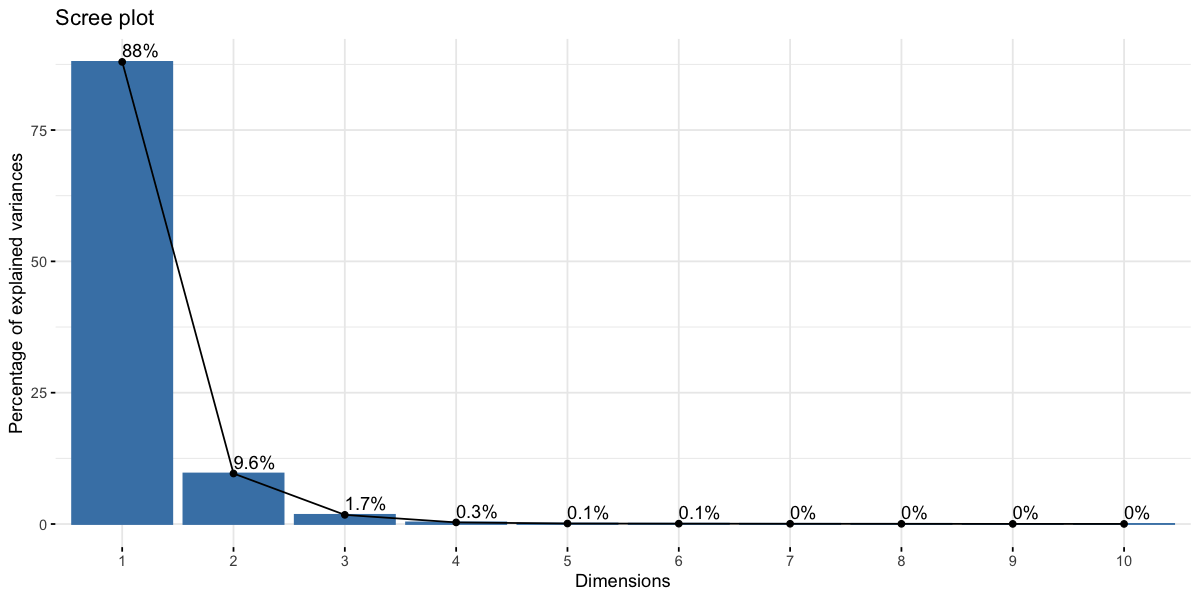

In [16]:
# PCA helps in identifying outlying samples for quality control and gives a feeling for the principal causes of 
# variation in a dataset

# Calculate principal components using transposed count data
pca <- prcomp(t(countdata))

options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(pca, addlabels = TRUE)

In [17]:
head(coldata)

,Subject_No,Subject_ID,Sample_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,1,AS_1,AS_1_C,F,B,NH,47,23.7,AS,C,Air
2,1,AS_1,AS_1_F,F,B,NH,47,23.7,AS,F,PGGLY
4,1,AS_1,AS_1_S,F,B,NH,47,23.7,AS,S,PGGLY
5,2,AS_2,AS_2_C,F,W,NH,19,19.5,AS,C,Air
6,2,AS_2,AS_2_F,F,W,NH,19,19.5,AS,F,PGGLY
8,2,AS_2,AS_2_S,F,W,NH,19,19.5,AS,S,PGGLY


In [18]:
# Make dataframe for PCA plot generation using first two components and the sample name
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], Sample_ID = colnames(countdata))

# Calculating percent of the variation that is captured by each principal component
pca_percent <- round(100 * pca$sdev^2/sum(pca$sdev^2), 1)

# Organize dataframe so we can color our points by burn condition
pca_df <- pca_df %>% 
    inner_join(coldata)

head(pca_df)

Joining with `by = join_by(Sample_ID)`


,PC1,PC2,Sample_ID,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,-55798.72,-40937.89,AS_1_C,1,AS_1,F,B,NH,47,23.7,AS,C,Air
2,-38290.55,-51666.91,AS_1_F,1,AS_1,F,B,NH,47,23.7,AS,F,PGGLY
3,-37880.24,-36709.06,AS_1_S,1,AS_1,F,B,NH,47,23.7,AS,S,PGGLY
4,-186314.62,-18295.99,AS_2_C,2,AS_2,F,W,NH,19,19.5,AS,C,Air
5,-208335.39,-12300.38,AS_2_F,2,AS_2,F,W,NH,19,19.5,AS,F,PGGLY
6,-178447.10,-19661.44,AS_2_S,2,AS_2,F,W,NH,19,19.5,AS,S,PGGLY


Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


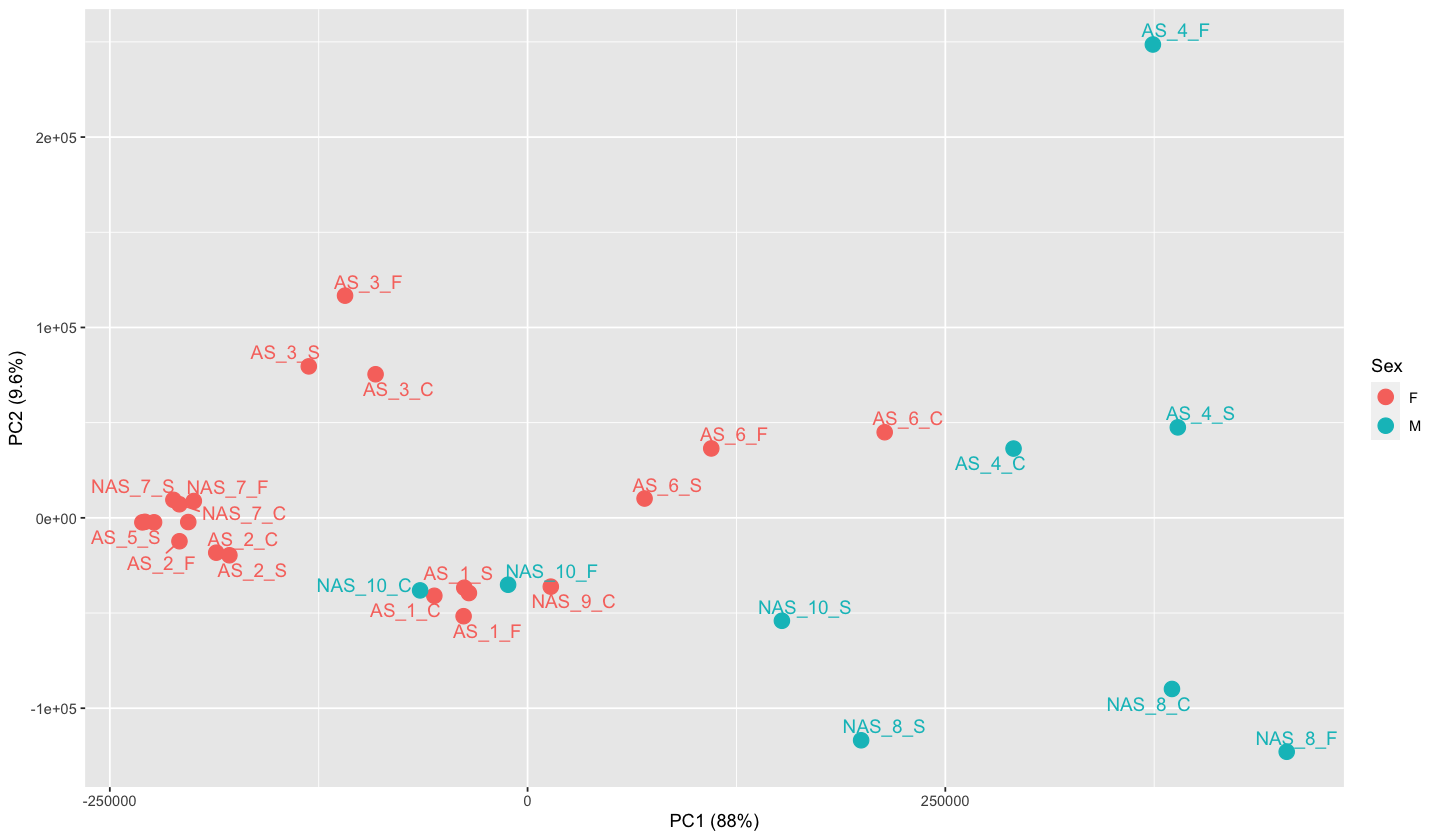

In [19]:
options(repr.plot.width=12, repr.plot.height=7) #changing size

# color by sex since that's a covariate we're interested in
ggplot(pca_df, aes(PC1, PC2, color = Sex)) +
  geom_point(size = 4) +
  geom_text_repel(aes(label = Sample_ID), size = 4) +
  labs(x = paste0("PC1 (",pca_percent[1],"%)"), y = paste0("PC2 (",pca_percent[2],"%)"))

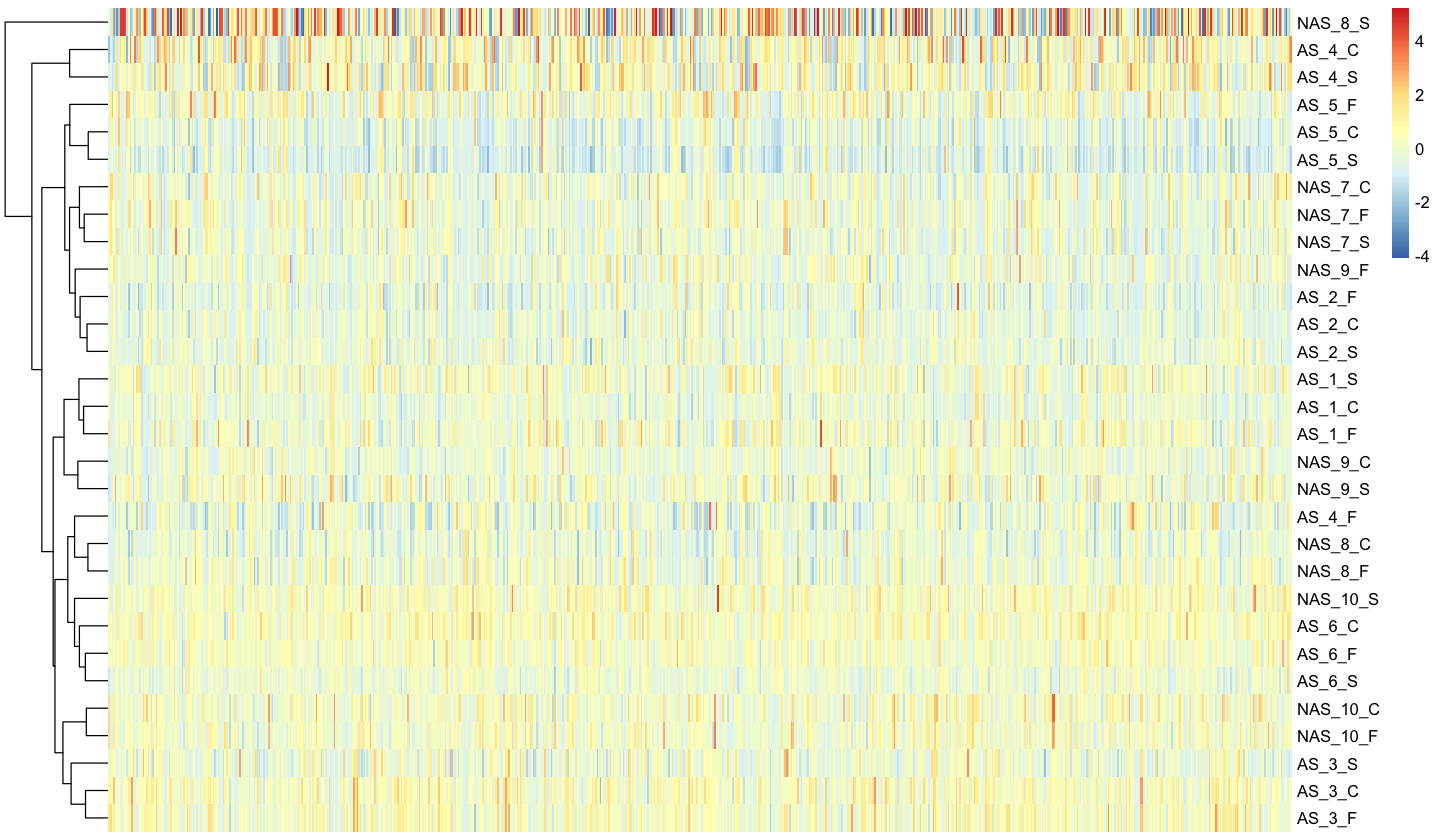

In [20]:
countdata_for_clustering <- t(countdata)

pheatmap(scale(countdata_for_clustering), 
         cluster_rows = TRUE, cluster_cols = FALSE, fontsize_col = 7, treeheight_row = 60, show_colnames = FALSE)

There were no clear sample outliers from PCA or hierarchical clustering, so now we'll use a quantitative approach. The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. source ADD!!!

In [21]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
gene_outliers = outlier_detection(pca)  

In [22]:
# getting length
length(gene_outliers)

[1] 0

# DESeq2 Experiment

In [23]:
# Starting with putting variables into factors
coldata$Disease_Status = factor(coldata$Disease_Status)
coldata$Exposure = factor(coldata$Exposure)
coldata$Sex = factor(coldata$Sex)
coldata$Subject_No = factor(coldata$Subject_No)

In [24]:
head(countdata)
head(coldata)

,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,AS_4_C,⋯,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A4GALT,4229,4976,4311,3736,3506,3853,4570,4959,3373,2236,⋯,4356,3006,3370,3906,3099,3544,2854,5229,5327,4469
AADAC,5,7,3,26,19,13,79,131,84,15,⋯,116,12,4,1,20,70,4,20,20,13
ABCA13,82,95,91,368,362,260,174,201,314,48,⋯,325,107,117,374,88,265,97,102,102,97
ABHD17C,556,524,575,816,814,696,1344,1039,765,298,⋯,919,518,541,66,583,1120,771,1018,1072,762
ABHD2,1135,1052,1523,791,698,931,840,806,972,674,⋯,725,906,974,1740,1350,914,1870,964,911,902
ABRACL,2518,2982,2879,1840,1895,2155,2594,2852,1901,3759,⋯,1606,2684,2608,170,2078,2023,2330,2968,3033,3482


,Subject_No,Subject_ID,Sample_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<fct>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>
1,1,AS_1,AS_1_C,F,B,NH,47,23.7,AS,C,Air
2,1,AS_1,AS_1_F,F,B,NH,47,23.7,AS,F,PGGLY
4,1,AS_1,AS_1_S,F,B,NH,47,23.7,AS,S,PGGLY
5,2,AS_2,AS_2_C,F,W,NH,19,19.5,AS,C,Air
6,2,AS_2,AS_2_F,F,W,NH,19,19.5,AS,F,PGGLY
8,2,AS_2,AS_2_S,F,W,NH,19,19.5,AS,S,PGGLY


We're intersted in comparing... 
- non-asthmatics to asthmatics
- exposure Exposures (control, freebase nicotine, and nicotine salt users)
- sex

> Design #1: Exposure
> 
> Design #2: Exposure + Disease Status
> 
> Design #3: Exposure + Disease Status + Sex

In [25]:
# Our design indicates that our count data is dependent on the exposure condition 
# (Exposure variable) and our factor of unwanted variation, and we have specified 
# that there not be an intercept term through the use of '~0'

# crude model
dds <- DESeqDataSetFromMatrix(countData = countdata, colData = coldata, design = ~Exposure) 
# adding disease status as a covariate
dds_ds <- DESeqDataSetFromMatrix(countData = countdata, colData = coldata, design = ~Exposure + Disease_Status) 
# adding in disease status and sex as covariates
dds_ds_sex <- DESeqDataSetFromMatrix(countData = countdata, colData = coldata, design = ~Exposure + Disease_Status + Sex) 

# View what the experiment contains
dds

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode



class: DESeqDataSet 
dim: 725 30 
metadata(1): version
assays(1): counts
rownames(725): A4GALT AADAC ... ZNF841_1 ZNF841_2
rowData names(0):
colnames(30): AS_1_C AS_1_F ... NAS_10_F NAS_10_S
colData names(11): Subject_No Subject_ID ... Exposure Medium

In [26]:
# make sure that we have the main contrast in the order we want to calculate appropriate fold change values
dds$Exposure <- relevel (dds$Exposure, "C")
dds_ds$Exposure <- relevel (dds_ds$Exposure, "C")
dds_ds_sex$Exposure <- relevel (dds_ds_sex$Exposure, "C")
# dds$Disease_Status <- relevel (dds$Disease_Status, "NAS")
# dds$Sex <- relevel (dds$Sex, "F")

# estimate the size factors, since size factors are used to normalize the counts (next step)
# The "iterate" estimator iterates between estimating the dispersion with a design of ~1, and finding a size factor vector by numerically 
# optimizing the likelihood of the ~1 model.
dds <- estimateSizeFactors(dds)
dds_ds <- estimateSizeFactors(dds_ds)
dds_ds_sex <- estimateSizeFactors(dds_ds_sex)

sizeFactors(dds) 
sizeFactors(dds_ds) 
sizeFactors(dds_ds_sex) 

AS_1_C    AS_1_F    AS_1_S    AS_2_C    AS_2_F    AS_2_S    AS_3_C    AS_3_F 
0.9482643 1.0352582 1.0407218 0.9298070 0.8775271 0.9417281 1.1397416 1.1420947 
   AS_3_S    AS_4_C    AS_4_F    AS_4_S    AS_5_C    AS_5_F    AS_5_S    AS_6_C 
0.9988806 1.1304081 0.9543240 1.1408709 0.8235622 1.0481038 0.7503790 1.1873988 
   AS_6_F    AS_6_S   NAS_7_C   NAS_7_F   NAS_7_S   NAS_8_C   NAS_8_F   NAS_8_S 
1.1203081 1.0082991 0.9854695 0.9861384 0.9335546 0.9529566 1.0183718 1.2121553 
  NAS_9_C   NAS_9_F   NAS_9_S  NAS_10_C  NAS_10_F  NAS_10_S 
0.9822509 0.9423136 1.0276522 1.0745840 1.0726448 1.1706556

AS_1_C    AS_1_F    AS_1_S    AS_2_C    AS_2_F    AS_2_S    AS_3_C    AS_3_F 
0.9482643 1.0352582 1.0407218 0.9298070 0.8775271 0.9417281 1.1397416 1.1420947 
   AS_3_S    AS_4_C    AS_4_F    AS_4_S    AS_5_C    AS_5_F    AS_5_S    AS_6_C 
0.9988806 1.1304081 0.9543240 1.1408709 0.8235622 1.0481038 0.7503790 1.1873988 
   AS_6_F    AS_6_S   NAS_7_C   NAS_7_F   NAS_7_S   NAS_8_C   NAS_8_F   NAS_8_S 
1.1203081 1.0082991 0.9854695 0.9861384 0.9335546 0.9529566 1.0183718 1.2121553 
  NAS_9_C   NAS_9_F   NAS_9_S  NAS_10_C  NAS_10_F  NAS_10_S 
0.9822509 0.9423136 1.0276522 1.0745840 1.0726448 1.1706556

AS_1_C    AS_1_F    AS_1_S    AS_2_C    AS_2_F    AS_2_S    AS_3_C    AS_3_F 
0.9482643 1.0352582 1.0407218 0.9298070 0.8775271 0.9417281 1.1397416 1.1420947 
   AS_3_S    AS_4_C    AS_4_F    AS_4_S    AS_5_C    AS_5_F    AS_5_S    AS_6_C 
0.9988806 1.1304081 0.9543240 1.1408709 0.8235622 1.0481038 0.7503790 1.1873988 
   AS_6_F    AS_6_S   NAS_7_C   NAS_7_F   NAS_7_S   NAS_8_C   NAS_8_F   NAS_8_S 
1.1203081 1.0082991 0.9854695 0.9861384 0.9335546 0.9529566 1.0183718 1.2121553 
  NAS_9_C   NAS_9_F   NAS_9_S  NAS_10_C  NAS_10_F  NAS_10_S 
0.9822509 0.9423136 1.0276522 1.0745840 1.0726448 1.1706556

In [27]:
# normalized counts
normcounts <- counts(dds, normalized = TRUE)
normcounts_ds <- counts(dds_ds, normalized = TRUE)
normcounts_ds_sex <- counts(dds_ds_sex, normalized = TRUE)

# log2 pseudocounts
log2normcounts <- log2(normcounts + 1)
log2normcounts_ds <- log2(normcounts_ds + 1)
log2normcounts_ds_sex <- log2(normcounts_ds_sex + 1)

In [28]:
# Background filter: remove rows with only zeros or only a single count across all samples
idx <- rowSums(normcounts) > 1     
CountsAboveBack <- normcounts[idx,]
nrow(CountsAboveBack)

idx_ds <- rowSums(normcounts_ds) > 1     
CountsAboveBack_ds <- normcounts_ds[idx_ds,]
nrow(CountsAboveBack_ds)

idx_ds_sex <- rowSums(normcounts_ds_sex) > 1     
CountsAboveBack_ds_sex <- normcounts_ds_sex[idx_ds_sex,]
nrow(CountsAboveBack_ds_sex)
    
# Also need to filter in the entire DESeq2 experiment
dds <- dds[rowSums(counts(dds, normalized = TRUE)) > 1, ]
dds_ds <- dds_ds[rowSums(counts(dds_ds, normalized = TRUE)) > 1, ]
dds_ds_sex <- dds_ds_sex[rowSums(counts(dds_ds_sex, normalized = TRUE)) > 1, ]

[1] 725

[1] 725

[1] 725

No genes were removed. 
# Statistical Analysis to detect Differentially Expressed Genes

In [29]:
# Running the differential expression statistical pipeline
# because we used a user-defined model matrix, need to set betaPrior = FALSE
dds <- DESeq(dds, betaPrior = FALSE) 
dds_ds <- DESeq(dds_ds, betaPrior = FALSE) 
dds_ds_sex <- DESeq(dds_ds_sex, betaPrior = FALSE) 

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [30]:
# creating a df of contrasts for the function to loop through
contrasts_df = data.frame(Exposure1 = c("C", "C", "S"), Exposure2 = c("S", "F", "F"))
head(contrasts_df)

,Exposure1,Exposure2
,<chr>,<chr>
1,C,S
2,C,F
3,S,F


In [46]:
#start of running loop to compare all samples
statistical_results = function(dds_experiment, covariates){
    
    significant_genes_df = data.frame()
    for (i in 1:length(contrasts_df$Exposure1)){
    
        # Pulling statistical results
        #Statistical output with multiple test correction by the default, BH (aka FDR)
        res <- results(dds_experiment, pAdjustMethod = "BH", contrast = c("Exposure", contrasts_df$Exposure1[i], contrasts_df$Exposure2[i]))
        
        # Exporting statistical results
        res_df = data.frame(res)[order(res$padj),] 
        filtered_res_df = res_df %>% 
            #filtering for only sig genes
            #filter(padj < 0.1) %>%
            # adding exposure comparisons
            mutate(Exposure1 = contrasts_df$Exposure1[i], Exposure2 = contrasts_df$Exposure2[i], Covariates = covariates) %>%
            rownames_to_column(var = "Gene")

        # saving results
        significant_genes_df = rbind(significant_genes_df, filtered_res_df)
        
      }
    
    return(significant_genes_df)
}

# calling function 
sig_genes_df = statistical_results(dds, "None")
sig_genes_ds_df = statistical_results(dds_ds, "Disease Status")
sig_genes_ds_sex_df = statistical_results(dds_ds_sex, "Disease Status + Sex")

head(sig_genes_df)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Exposure1,Exposure2,Covariates
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,KLF4,923.11601,-0.9743332,0.1835047,-5.309581,1.098776e-07,7.966129e-05,C,S,None
2,CSF3_1,70.09449,-2.8418923,0.7809307,-3.639110,2.735823e-04,9.917358e-02,C,S,None
3,NCOA7,2005.62251,-0.7240906,0.2077258,-3.485799,4.906687e-04,1.185783e-01,C,S,None
4,NFIL3,67.07713,-0.7371617,0.2215483,-3.327319,8.768606e-04,1.271448e-01,C,S,None
5,ZC3H12C,305.31619,-0.6865087,0.2050402,-3.348167,8.134801e-04,1.271448e-01,C,S,None
6,EIF2AK3,571.72427,-0.4722865,0.1546549,-3.053808,2.259563e-03,2.730305e-01,C,S,None


In [47]:
# table of asthma genes that were statistically significant
final_sig_df = rbind(sig_genes_df, sig_genes_ds_df, sig_genes_ds_sex_df)
head(final_sig_df)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Exposure1,Exposure2,Covariates
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,KLF4,923.11601,-0.9743332,0.1835047,-5.309581,1.098776e-07,7.966129e-05,C,S,None
2,CSF3_1,70.09449,-2.8418923,0.7809307,-3.639110,2.735823e-04,9.917358e-02,C,S,None
3,NCOA7,2005.62251,-0.7240906,0.2077258,-3.485799,4.906687e-04,1.185783e-01,C,S,None
4,NFIL3,67.07713,-0.7371617,0.2215483,-3.327319,8.768606e-04,1.271448e-01,C,S,None
5,ZC3H12C,305.31619,-0.6865087,0.2050402,-3.348167,8.134801e-04,1.271448e-01,C,S,None
6,EIF2AK3,571.72427,-0.4722865,0.1546549,-3.053808,2.259563e-03,2.730305e-01,C,S,None


In [48]:
# total gene counts
sig_genes_count_df = final_sig_df %>%
    group_by(Covariates) %>%
    summarize(n())

sig_genes_count_df

Covariates,n()
<chr>,<int>
Disease Status,2175
Disease Status + Sex,2175
None,2175


In [49]:
# exporting
write.xlsx(sig_genes_df, paste0(Output,"/", "Asthma_Genes_DESeq2_", cur_date, ".xlsx"), 
           rowNames = FALSE)